<a href="https://colab.research.google.com/github/Dhay112233/Dhay/blob/main/DataSet1_70_30.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import libraries

In [1]:
!pip install optuna
!pip install roboflow
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.9/80.9 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 4.8 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.5/887.5 kB 18.4 MB/s eta 0:00:00


In [3]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import optuna
import shutil
import tensorflow as tf
import cv2
import torch
import optuna.visualization as vis
import matplotlib.pyplot as plt
import joblib  # Import joblib to save the model

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, hinge_loss
from ultralytics import YOLO
from PIL import Image
from roboflow import Roboflow
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


#1. Dataset Loading
- Use Roboflow

###CNN and RecNet50 and SVM

In [4]:
rf = Roboflow(api_key="gG7AAopeR1epmUWtlp6y")
project = rf.workspace("brainhack22").project("fallen-people---training-dataset-complete")
version = project.version(2)
dataset = version.download("tensorflow")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Fallen-People---Training-Dataset-Complete-2 in tensorflow:: 100%|██████████| 15823/15823 [00:13<00:00, 1185.51it/s]


###YOLO

In [ ]:
rf = Roboflow(api_key="gG7AAopeR1epmUWtlp6y")
project = rf.workspace("brainhack22").project("fallen-people---training-dataset-complete")
version = project.version(2)
dataset = version.download("yolov8")


loading Roboflow workspace...
loading Roboflow project...


# 2. Dataset Preparation " Mining"


##1. Organizing Image Data Based on Annotations
 - changeing the structuer of the dataset to CNN structuer




In [5]:
import os
import shutil

# Paths to your dataset directories
train_dir = '/content/Fallen-People---Training-Dataset-Complete-2/train'
val_dir = '/content/Fallen-People---Training-Dataset-Complete-2/valid'
test_dir = '/content/Fallen-People---Training-Dataset-Complete-2/test'

# New directory to save the combined dataset
combined_dir = 'combined_dataset'
os.makedirs(combined_dir, exist_ok=True)

# Function to copy files from source to destination
def copy_files(src_dir):
    for filename in os.listdir(src_dir):
        if filename.endswith(('.jpg', '.png', '.jpeg')):  # Adjust extensions as necessary
            src_file = os.path.join(src_dir, filename)
            dst_file = os.path.join(combined_dir, filename)
            shutil.copy(src_file, dst_file)

# Copying images from each dataset
copy_files(train_dir)
copy_files(val_dir)
copy_files(test_dir)

print("Images have been copied to the combined dataset directory.")

Images have been copied to the combined dataset directory.


In [ ]:
def check_image_datasets(directories):
    # List to hold image file paths and their corresponding hashes
    image_data = []

    # Iterate through all provided directories
    for directory in directories:
        if not os.path.isdir(directory):
            print(f"Directory does not exist: {directory}")
            continue

        # Iterate through all files in the directory
        for filename in os.listdir(directory):
            file_path = os.path.join(directory, filename)

            # Check if the file is an image
            try:
                with Image.open(file_path) as img:
                    # Convert image to a hash
                    img_hash = hash(img.tobytes())
                    image_data.append((filename, img_hash))
            except Exception as e:
                print(f"Could not open {file_path}: {e}")

    # Create a DataFrame
    df = pd.DataFrame(image_data, columns=['filename', 'hash'])

    # Check for duplicates
    duplicate_images = df[df.duplicated(subset='hash', keep=False)]

    # Output results
    if not duplicate_images.empty:
        print("Duplicate images found:")
        print(duplicate_images)
    else:
        print("No duplicate images found.")

def delete_duplicate_images(directories):
    # List to hold image file paths and their corresponding hashes
    image_data = []
    hash_map = {}

    # Iterate through all provided directories
    for directory in directories:
        if not os.path.isdir(directory):
            print(f"Directory does not exist: {directory}")
            continue

        # Iterate through all files in the directory
        for filename in os.listdir(directory):
            file_path = os.path.join(directory, filename)

            # Check if the file is an image
            try:
                with Image.open(file_path) as img:
                    # Convert image to a hash
                    img_hash = hash(img.tobytes())
                    image_data.append((filename, img_hash))

                    # Store the file path in the hash map
                    if img_hash in hash_map:
                        hash_map[img_hash].append(file_path)
                    else:
                        hash_map[img_hash] = [file_path]
            except Exception as e:
                print(f"Could not open {file_path}: {e}")

    # Identify and delete duplicate images
    duplicates_found = False
    for paths in hash_map.values():
        if len(paths) > 1:
            duplicates_found = True
            # Keep the first image and delete the others
            for path in paths[1:]:
                print(f"Deleting duplicate image: {path}")
                os.remove(path)

    if not duplicates_found:
        print("No duplicate images found.")

# Specify the directories containing your images
image_directories = [
    '/content/combined_dataset'
]

# Check for duplicates
check_image_datasets(image_directories)

# Optionally, delete duplicates
delete_duplicate_images(image_directories)

Duplicate images found:
                                                filename                 hash
3063   XI8lGefDnWu47IrbJXkGTjs0ud_jpg.rf.88ef9c556673...  2899176386962864205
6575   CkYvAfLbZmJ2L914bsWdOl8tri_jpg.rf.e78d43c83e4b... -3944967375425884795
6754   RFvhNHrmqDA8fnIjJswuNii3RO_jpg.rf.07dc35ebd282...  8357354341954285338
9098   XI8lGefDnWu47IrbJXkGTjs0ud_jpg.rf.2d092b899317...  2899176386962864205
9869   4qidYcZV01X4FF3RE1GrT5xSdl_jpg.rf.12674d5c2c76...  4806258842307555354
12716  4qidYcZV01X4FF3RE1GrT5xSdl_jpg.rf.802ffadd1ca5...  4806258842307555354
12936  CkYvAfLbZmJ2L914bsWdOl8tri_jpg.rf.00fe0fb1f764... -3944967375425884795
14965  RFvhNHrmqDA8fnIjJswuNii3RO_jpg.rf.3939a2cea2a9...  8357354341954285338
Deleting duplicate image: /content/combined_dataset/XI8lGefDnWu47IrbJXkGTjs0ud_jpg.rf.2d092b899317afb797fd604d5c1b238e.jpg
Deleting duplicate image: /content/combined_dataset/CkYvAfLbZmJ2L914bsWdOl8tri_jpg.rf.00fe0fb1f7644d2f87261a7d9727066c.jpg
Deleting duplicate image: /c

In [8]:
import os
import shutil
import pandas as pd

# Path to your combined dataset directory
combined_dir = '/content/combined_dataset'

# Create directories for training and testing sets
train_dir = 'train_dataset'
test_dir = 'test_dataset'

os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Load the annotation files
train_annotations = pd.read_csv('/content/train_annotations.csv')  # Adjust the path as needed
test_annotations = pd.read_csv('/content/test_annotations.csv')    # Adjust the path as needed
valid_annotations = pd.read_csv('/content/valid_annotations.csv')  # Adjust the path as needed

# Combine all annotations into a single DataFrame
all_annotations = pd.concat([train_annotations, test_annotations, valid_annotations], ignore_index=True)

# Shuffle the combined annotations
all_annotations = all_annotations.sample(frac=1).reset_index(drop=True)  # Shuffle the DataFrame

# Calculate split sizes
total_images = len(all_annotations)
train_size = int(0.7 * total_images)  # 70% for training
test_size = total_images - train_size  # 30% for testing

# Split into training and testing
train_annotations = all_annotations[:train_size]
test_annotations = all_annotations[train_size:]

# Function to distribute files into class folders based on annotations
def distribute_files(annotations, dst_dir):
    for index, row in annotations.iterrows():
        filename = row['filename']
        class_label = row['class']

        src_file = os.path.join(combined_dir, filename)

        if os.path.exists(src_file):  # Check if the file exists
            class_dir = os.path.join(dst_dir, class_label)
            os.makedirs(class_dir, exist_ok=True)
            dst_file = os.path.join(class_dir, filename)
            shutil.copy(src_file, dst_file)
        else:
            print(f"File {filename} not found in {combined_dir}")

# Distributing files into class folders for training and testing
distribute_files(train_annotations, train_dir)
distribute_files(test_annotations, test_dir)

print(f"Training set: {len(train_annotations)} images")
print(f"Testing set: {len(test_annotations)} images")

Training set: 46445 images
Testing set: 19905 images


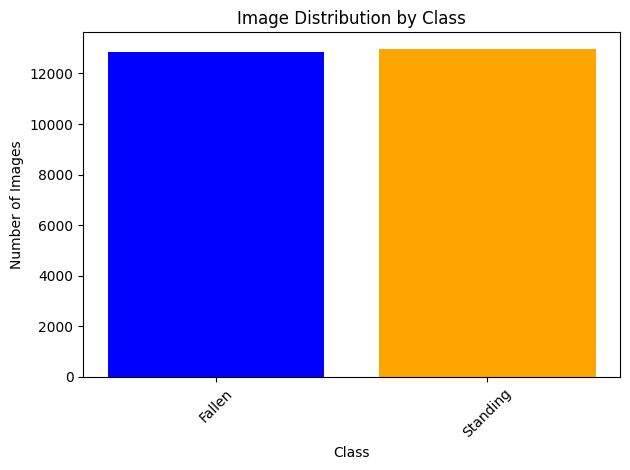

In [ ]:
import os
import matplotlib.pyplot as plt
from collections import Counter

# Define the path to your dataset
dataset_path = '/content/train_dataset'

# Initialize a counter
class_counts = Counter()

# Loop through each class folder and count the images
for class_name in ['Fallen', 'Standing']:
    class_path = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_path):
        num_images = len(os.listdir(class_path))
        class_counts[class_name] = num_images

# Prepare data for plotting
classes = list(class_counts.keys())
counts = list(class_counts.values())

# Create a bar chart
plt.bar(classes, counts, color=['blue', 'orange'])
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Image Distribution by Class')
plt.xticks(rotation=45)
plt.tight_layout()

# Show the chart
plt.show()

##2. Dataset Cleaning

- Checking for Image Existence

- Finding Duplicate Images

- Deleting Duplicate Images

###Check for CNN and RecNet50 and SVM

In [9]:
def check_image_datasets(directories):
    # List to hold image file paths and their corresponding hashes
    image_data = []

    # Iterate through all provided directories
    for directory in directories:
        if not os.path.isdir(directory):
            print(f"Directory does not exist: {directory}")
            continue

        # Iterate through all files in the directory
        for filename in os.listdir(directory):
            file_path = os.path.join(directory, filename)

            # Check if the file is an image
            try:
                with Image.open(file_path) as img:
                    # Convert image to a hash
                    img_hash = hash(img.tobytes())
                    image_data.append((filename, img_hash))
            except Exception as e:
                print(f"Could not open {file_path}: {e}")

    # Create a DataFrame
    df = pd.DataFrame(image_data, columns=['filename', 'hash'])

    # Check for duplicates
    duplicate_images = df[df.duplicated(subset='hash', keep=False)]

    # Output results
    if not duplicate_images.empty:
        print("Duplicate images found:")
        print(duplicate_images)
    else:
        print("No duplicate images found.")

def delete_duplicate_images(directories):
    # List to hold image file paths and their corresponding hashes
    image_data = []
    hash_map = {}

    # Iterate through all provided directories
    for directory in directories:
        if not os.path.isdir(directory):
            print(f"Directory does not exist: {directory}")
            continue

        # Iterate through all files in the directory
        for filename in os.listdir(directory):
            file_path = os.path.join(directory, filename)

            # Check if the file is an image
            try:
                with Image.open(file_path) as img:
                    # Convert image to a hash
                    img_hash = hash(img.tobytes())
                    image_data.append((filename, img_hash))

                    # Store the file path in the hash map
                    if img_hash in hash_map:
                        hash_map[img_hash].append(file_path)
                    else:
                        hash_map[img_hash] = [file_path]
            except Exception as e:
                print(f"Could not open {file_path}: {e}")

    # Identify and delete duplicate images
    duplicates_found = False
    for paths in hash_map.values():
        if len(paths) > 1:
            duplicates_found = True
            # Keep the first image and delete the others
            for path in paths[1:]:
                print(f"Deleting duplicate image: {path}")
                os.remove(path)

    if not duplicates_found:
        print("No duplicate images found.")

# Specify the directories containing your images
image_directories = [
    '/content/train_dataset/Fallen',
    '/content/train_dataset/Standing',
    '/content/test_dataset/Fallen',
    '/content/test_dataset/Standing'

]

# Check for duplicates
check_image_datasets(image_directories)

# Optionally, delete duplicates
delete_duplicate_images(image_directories)

Streaming output truncated to the last 5000 lines.
Deleting duplicate image: /content/test_dataset/Standing/sDwcXoWN5GyjmPjDJf5xiQeA7P_jpg.rf.bc5e80a76e8e67135947fc48e592e8c8.jpg
Deleting duplicate image: /content/train_dataset/Standing/lArJkOjMvtPKCLedVvBuc3TuN3_jpg.rf.d63542376ec6614c88b296b52b4a269b.jpg
Deleting duplicate image: /content/test_dataset/Fallen/lArJkOjMvtPKCLedVvBuc3TuN3_jpg.rf.d63542376ec6614c88b296b52b4a269b.jpg
Deleting duplicate image: /content/train_dataset/Standing/jHPQNZxd1SB7wTznutuJnW9vHH_jpg.rf.8b76524cd2397d5ac24f03175ee719ea.jpg
Deleting duplicate image: /content/test_dataset/Fallen/jHPQNZxd1SB7wTznutuJnW9vHH_jpg.rf.8b76524cd2397d5ac24f03175ee719ea.jpg
Deleting duplicate image: /content/test_dataset/Standing/jHPQNZxd1SB7wTznutuJnW9vHH_jpg.rf.8b76524cd2397d5ac24f03175ee719ea.jpg
Deleting duplicate image: /content/train_dataset/Standing/dZiUzss0XTq44h0aYvoyYQhHMR_jpg.rf.b33616dddeecf1d3fb2185c22f4d2c93.jpg
Deleting duplicate image: /content/test_dataset/Fallen

###Check for YOLO

In [ ]:
def check_image_datasets(directories):
    # List to hold image file paths and their corresponding hashes
    image_data = []

    # Iterate through all provided directories
    for directory in directories:
        if not os.path.isdir(directory):
            print(f"Directory does not exist: {directory}")
            continue

        # Iterate through all files in the directory
        for filename in os.listdir(directory):
            file_path = os.path.join(directory, filename)

            # Check if the file is an image
            try:
                with Image.open(file_path) as img:
                    # Convert image to a hash
                    img_hash = hash(img.tobytes())
                    image_data.append((filename, img_hash))
            except Exception as e:
                print(f"Could not open {file_path}: {e}")

    # Create a DataFrame
    df = pd.DataFrame(image_data, columns=['filename', 'hash'])

    # Check for duplicates
    duplicate_images = df[df.duplicated(subset='hash', keep=False)]

    # Output results
    if not duplicate_images.empty:
        print("Duplicate images found:")
        print(duplicate_images)
    else:
        print("No duplicate images found.")

def delete_duplicate_images(directories):
    # List to hold image file paths and their corresponding hashes
    hash_map = {}

    # Iterate through all provided directories
    for directory in directories:
        if not os.path.isdir(directory):
            print(f"Directory does not exist: {directory}")
            continue

        # Iterate through all files in the directory
        for filename in os.listdir(directory):
            file_path = os.path.join(directory, filename)

            # Check if the file is an image
            try:
                with Image.open(file_path) as img:
                    # Convert image to a hash
                    img_hash = hash(img.tobytes())

                    # Store the file path in the hash map
                    if img_hash in hash_map:
                        hash_map[img_hash].append(file_path)
                    else:
                        hash_map[img_hash] = [file_path]
            except Exception as e:
                print(f"Could not open {file_path}: {e}")

    # Identify and delete duplicate images
    duplicates_found = False
    for paths in hash_map.values():
        if len(paths) > 1:
            duplicates_found = True
            # Keep the first image and delete the others
            for path in paths[1:]:
                print(f"Deleting duplicate image: {path}")
                os.remove(path)

    if not duplicates_found:
        print("No duplicate images found.")

# Specify the directories containing your images
image_directories = [
    '/content/Fallen-People---Training-Dataset-Complete-2/train/images',
    '/content/Fallen-People---Training-Dataset-Complete-2/valid/images',
    '/content/Fallen-People---Training-Dataset-Complete-2/test/images'
]

# Check for duplicates
check_image_datasets(image_directories)

# Optionally, delete duplicates
delete_duplicate_images(image_directories)

Directory does not exist: /content/Fallen-People---Training-Dataset-Complete-2/train/images
Directory does not exist: /content/Fallen-People---Training-Dataset-Complete-2/valid/images
Directory does not exist: /content/Fallen-People---Training-Dataset-Complete-2/test/images
No duplicate images found.
Directory does not exist: /content/Fallen-People---Training-Dataset-Complete-2/train/images
Directory does not exist: /content/Fallen-People---Training-Dataset-Complete-2/valid/images
Directory does not exist: /content/Fallen-People---Training-Dataset-Complete-2/test/images
No duplicate images found.


# 3. Data Processing

## 1. Data augmentation

In [10]:
# Data augmentation and preprocessing for training.
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Preprocessing for validation and test data.
test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

#4.Build the Model

## 1.Define Data Directory Paths and loading data

###1. Set parameters

In [11]:
# 2. Set parameters
img_height, img_width = 224, 224
batch_size = 16
epochs = 10
learning_rate = 0.001  # Fixed learning rate

###2. Loading Data

#### CNN and ResNet50

In [12]:
# Specify the paths for training, validation, and test datasets.
train_data_dir = '/content/train_dataset'  # Update this path
#val_data_dir = '/content/faint_detection_newdataset/validate'  # Update this path
test_data_dir = '/content/test_dataset'    # Update this path


# Load training data
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
)

# Load validation data
#val_generator = test_datagen.flow_from_directory(
   # val_data_dir,
   # target_size=(img_height, img_width),
  #  batch_size=batch_size,
   # class_mode='binary',
  #  shuffle=False
#)

# Load test data
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

Found 15361 images belonging to 2 classes.
Found 441 images belonging to 2 classes.


In [ ]:
def check_image_datasets(directories):
    # List to hold image file paths and their corresponding hashes
    image_data = []

    # Iterate through all provided directories
    for directory in directories:
        if not os.path.isdir(directory):
            print(f"Directory does not exist: {directory}")
            continue

        # Iterate through all files in the directory
        for filename in os.listdir(directory):
            file_path = os.path.join(directory, filename)

            # Check if the file is an image
            try:
                with Image.open(file_path) as img:
                    # Convert image to a hash
                    img_hash = hash(img.tobytes())
                    image_data.append((filename, img_hash))
            except Exception as e:
                print(f"Could not open {file_path}: {e}")

    # Create a DataFrame
    df = pd.DataFrame(image_data, columns=['filename', 'hash'])

    # Check for duplicates
    duplicate_images = df[df.duplicated(subset='hash', keep=False)]

    # Output results
    if not duplicate_images.empty:
        print("Duplicate images found:")
        print(duplicate_images)
    else:
        print("No duplicate images found.")

def delete_duplicate_images(directories):
    # List to hold image file paths and their corresponding hashes
    image_data = []
    hash_map = {}

    # Iterate through all provided directories
    for directory in directories:
        if not os.path.isdir(directory):
            print(f"Directory does not exist: {directory}")
            continue

        # Iterate through all files in the directory
        for filename in os.listdir(directory):
            file_path = os.path.join(directory, filename)

            # Check if the file is an image
            try:
                with Image.open(file_path) as img:
                    # Convert image to a hash
                    img_hash = hash(img.tobytes())
                    image_data.append((filename, img_hash))

                    # Store the file path in the hash map
                    if img_hash in hash_map:
                        hash_map[img_hash].append(file_path)
                    else:
                        hash_map[img_hash] = [file_path]
            except Exception as e:
                print(f"Could not open {file_path}: {e}")

    # Identify and delete duplicate images
    duplicates_found = False
    for paths in hash_map.values():
        if len(paths) > 1:
            duplicates_found = True
            # Keep the first image and delete the others
            for path in paths[1:]:
                print(f"Deleting duplicate image: {path}")
                os.remove(path)

    if not duplicates_found:
        print("No duplicate images found.")

# Specify the directories containing your images
image_directories = [
    '/content/train_dataset/Fallen',
    '/content/train_dataset/Standing',
    '/content/test_dataset/Fallen',
    '/content/test_dataset/Standing'

]

# Check for duplicates
check_image_datasets(image_directories)

# Optionally, delete duplicates
delete_duplicate_images(image_directories)

No duplicate images found.
No duplicate images found.


#### SVM

In [ ]:
# Function to load data from directoriesاتوقع هالكود خطأ وما اشتغل عند احد
def load_data(base_dir):
    X = []
    y = []
    class_names = os.listdir(base_dir)

    for class_index, class_name in enumerate(class_names):
        class_dir = os.path.join(base_dir, class_name)
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            img = cv2.imread(img_path)
            img_resized = cv2.resize(img, (64, 64))  # Resize images to 64x64
            X.append(img_resized.flatten())  # Flatten the image
            y.append(class_index)

    return np.array(X), np.array(y)

# Load datasets
X_train, y_train = load_data('/content/train_dataset')
 #X_valid, y_valid = load_data('/content/faint_detection_newdataset/validate')
X_test, y_test = load_data('/content/test_dataset')

KeyboardInterrupt: 

##3. Models:

- Use Optuna




###CNN

In [ ]:
# Imports
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from google.colab import files
import matplotlib.pyplot as plt

# Define the objective function for Optuna
def objective_CNN(trial):
    model_CNN = models.Sequential()
    model_CNN.add(layers.Input(shape=(img_height, img_width, 3)))

    # Suggest hyperparameters
    conv_units = trial.suggest_int('conv_units', 32, 128)
    model_CNN.add(layers.Conv2D(conv_units, (3, 3), activation='relu'))
    model_CNN.add(layers.MaxPooling2D(pool_size=(2, 2)))

    conv_units2 = trial.suggest_int('conv_units2', 64, 256)
    model_CNN.add(layers.Conv2D(conv_units2, (3, 3), activation='relu'))
    model_CNN.add(layers.MaxPooling2D(pool_size=(2, 2)))

    model_CNN.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model_CNN.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model_CNN.add(layers.Flatten())

    dense_units = trial.suggest_int('dense_units', 64, 256)
    model_CNN.add(layers.Dense(dense_units, activation='relu'))
    model_CNN.add(layers.Dense(1, activation='sigmoid'))

    # Compile the model
    learning_rate = trial.suggest_loguniform('lr', 1e-5, 1e-1)
    model_CNN.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                       loss='binary_crossentropy',
                       metrics=['accuracy'])

    # Suggest number of epochs
    max_epochs = trial.suggest_int('epochs', 5, 10)  # Adjust range as needed

    # Callbacks for early stopping and model checkpointing
    early_stopping = EarlyStopping(monitor='loss', patience=5, verbose=1, restore_best_weights=True)
    model_checkpoint = ModelCheckpoint('best_model.keras', monitor='accuracy', save_best_only=True, mode='max')

    # Train the model and capture the training history
    history = model_CNN.fit(
        train_generator,
        epochs=max_epochs,
        steps_per_epoch=train_generator.samples // batch_size,
        callbacks=[early_stopping, model_checkpoint],
        verbose=0
    )

    # Evaluate the model on the test set
    test_loss, test_accuracy = model_CNN.evaluate(test_generator, steps=test_generator.samples // batch_size)

    # Plot training accuracy and loss
    plt.figure(figsize=(12, 4))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.axhline(y=test_accuracy, color='r', linestyle='--', label='Test Accuracy')  # Add test accuracy line
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.axhline(y=test_loss, color='r', linestyle='--', label='Test Loss')  # Add test loss line
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

    # Save the model to a file
    model_CNN.save('final_model.keras')

    # Download the model to your local machine
    files.download('final_model.keras')

    # Return the test accuracy
    return test_accuracy

In [13]:
# Define the objective function for Optuna
def objective_CNN(trial):
    model_CNN = models.Sequential()
    model_CNN.add(layers.Input(shape=(img_height, img_width, 3)))

    # Suggest hyperparameters
    conv_units = trial.suggest_int('conv_units', 32, 128)
    model_CNN.add(layers.Conv2D(conv_units, (3, 3), activation='relu'))
    model_CNN.add(layers.MaxPooling2D(pool_size=(2, 2)))

    conv_units2 = trial.suggest_int('conv_units2', 64, 256)
    model_CNN.add(layers.Conv2D(conv_units2, (3, 3), activation='relu'))
    model_CNN.add(layers.MaxPooling2D(pool_size=(2, 2)))

    model_CNN.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model_CNN.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model_CNN.add(layers.Flatten())

    dense_units = trial.suggest_int('dense_units', 64, 256)
    model_CNN.add(layers.Dense(dense_units, activation='relu'))
    model_CNN.add(layers.Dense(1, activation='sigmoid'))

    # Compile the model
    learning_rate = trial.suggest_loguniform('lr', 1e-5, 1e-1)
    model_CNN.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                       loss='binary_crossentropy',
                       metrics=['accuracy'])

    # Suggest number of epochs
    max_epochs = trial.suggest_int('epochs', 5, 10)  # Adjust range as needed

    # Callbacks for early stopping and model checkpointing
    early_stopping = EarlyStopping(monitor='loss', patience=5, verbose=1, restore_best_weights=True)
    model_checkpoint = ModelCheckpoint('best_model.keras', monitor='accuracy', save_best_only=True, mode='max')

    # Train the model and capture the training history
    history = model_CNN.fit(
        train_generator,
        epochs=max_epochs,
        steps_per_epoch=train_generator.samples // batch_size,
        callbacks=[early_stopping, model_checkpoint],
        verbose=0
    )

    # Evaluate the model on the test set
    test_loss, test_accuracy = model_CNN.evaluate(test_generator, steps=test_generator.samples // batch_size)

    # Return the test accuracy
    return test_accuracy

In [14]:
# Create a study and optimize
study_CNN = optuna.create_study(direction='maximize')
study_CNN.optimize(objective_CNN, n_trials=10)  # Adjust n_trials as needed

# Print the best hyperparameters
print("Best trial:")
trial = study_CNN.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-11-25 15:21:00,392] A new study created in memory with name: no-name-57d5a1c2-910c-450b-b592-3d7a768d3c94
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.


Restoring model weights from the end of the best epoch: 6.
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 99ms/step - accuracy: 0.9575 - loss: 0.3149


[I 2024-11-25 15:42:47,739] Trial 0 finished with value: 0.8333333134651184 and parameters: {'conv_units': 42, 'conv_units2': 144, 'dense_units': 72, 'lr': 1.939411274925622e-05, 'epochs': 10}. Best is trial 0 with value: 0.8333333134651184.


Restoring model weights from the end of the best epoch: 2.
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - accuracy: 0.9573 - loss: 0.2102


[I 2024-11-25 15:56:05,856] Trial 1 finished with value: 0.8009259104728699 and parameters: {'conv_units': 113, 'conv_units2': 89, 'dense_units': 74, 'lr': 2.1237927116445867e-05, 'epochs': 5}. Best is trial 0 with value: 0.8333333134651184.


Restoring model weights from the end of the best epoch: 2.
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 97ms/step - accuracy: 0.9403 - loss: 0.3156


[I 2024-11-25 16:10:01,555] Trial 2 finished with value: 0.8263888955116272 and parameters: {'conv_units': 88, 'conv_units2': 81, 'dense_units': 160, 'lr': 0.000526003450409064, 'epochs': 5}. Best is trial 0 with value: 0.8333333134651184.


Restoring model weights from the end of the best epoch: 2.
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 118ms/step - accuracy: 0.9562 - loss: 0.2626


[I 2024-11-25 16:23:56,655] Trial 3 finished with value: 0.8356481194496155 and parameters: {'conv_units': 127, 'conv_units2': 245, 'dense_units': 240, 'lr': 0.0013714884483241208, 'epochs': 6}. Best is trial 3 with value: 0.8356481194496155.


Restoring model weights from the end of the best epoch: 9.
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - accuracy: 0.9497 - loss: 0.2671


[I 2024-11-25 16:45:47,617] Trial 4 finished with value: 0.7384259104728699 and parameters: {'conv_units': 71, 'conv_units2': 65, 'dense_units': 213, 'lr': 0.004828298863562768, 'epochs': 9}. Best is trial 3 with value: 0.8356481194496155.


Restoring model weights from the end of the best epoch: 3.
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 102ms/step - accuracy: 0.9497 - loss: 0.2608


[I 2024-11-25 17:03:00,569] Trial 5 finished with value: 0.7384259104728699 and parameters: {'conv_units': 82, 'conv_units2': 77, 'dense_units': 102, 'lr': 0.04251722432211584, 'epochs': 7}. Best is trial 3 with value: 0.8356481194496155.


Epoch 7: early stopping
Restoring model weights from the end of the best epoch: 2.
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - accuracy: 0.9580 - loss: 0.3083


[I 2024-11-25 17:23:37,130] Trial 6 finished with value: 0.8356481194496155 and parameters: {'conv_units': 64, 'conv_units2': 252, 'dense_units': 188, 'lr': 0.00012159320842934063, 'epochs': 8}. Best is trial 3 with value: 0.8356481194496155.


Restoring model weights from the end of the best epoch: 4.
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 69ms/step - accuracy: 0.9572 - loss: 0.2521


[I 2024-11-25 17:38:07,802] Trial 7 finished with value: 0.8402777910232544 and parameters: {'conv_units': 79, 'conv_units2': 187, 'dense_units': 228, 'lr': 7.581949944517291e-05, 'epochs': 5}. Best is trial 7 with value: 0.8402777910232544.


Epoch 9: early stopping
Restoring model weights from the end of the best epoch: 4.
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - accuracy: 0.9497 - loss: 0.2400


[I 2024-11-25 18:00:55,571] Trial 8 finished with value: 0.7384259104728699 and parameters: {'conv_units': 40, 'conv_units2': 254, 'dense_units': 78, 'lr': 0.05166834475254012, 'epochs': 10}. Best is trial 7 with value: 0.8402777910232544.


Restoring model weights from the end of the best epoch: 7.
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - accuracy: 0.9610 - loss: 0.2979


[I 2024-11-25 18:19:39,537] Trial 9 finished with value: 0.8472222089767456 and parameters: {'conv_units': 117, 'conv_units2': 143, 'dense_units': 195, 'lr': 7.06738897349631e-05, 'epochs': 8}. Best is trial 9 with value: 0.8472222089767456.


Best trial:
  Value: 0.8472222089767456
  Params: 
    conv_units: 117
    conv_units2: 143
    dense_units: 195
    lr: 7.06738897349631e-05
    epochs: 8


In [15]:
# Plot optimization history
vis.plot_optimization_history(study_CNN)

# Plot parallel coordinate plot
vis.plot_parallel_coordinate(study_CNN)

# Load the best saved model
best_model_CNN = tf.keras.models.load_model('best_model.keras')

# Print the summary of the best model
print("\nBest Model Summary:")
best_model_CNN.summary()

# Visualize the model architecture
plot_model(best_model_CNN, to_file='best_model_architecture.png', show_shapes=True, show_layer_names=True)

# Evaluate the best model on the test set
test_loss, test_accuracy = best_model_CNN.evaluate(test_generator, steps=test_generator.samples // batch_size)
print(f'Test accuracy of the best model: {test_accuracy:.2f}')


Best Model Summary:


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_27 (Conv2D)                   │ (None, 222, 222, 117)       │           3,276 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_27 (MaxPooling2D)      │ (None, 111, 111, 117)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_28 (Conv2D)                   │ (None, 109, 109, 143)       │         150,722 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_28 (MaxPooling2D)      │ (None, 54, 54, 143)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_29 (Conv2D)                   │ (None, 52, 52, 128)         │         164,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_29 (MaxPooling2D)      │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_9 (Flatten)                  │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 195)                 │      16,873,155 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 1)                   │             196 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 51,576,641 (196.75 MB)

 Trainable params: 17,192,213 (65.58 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 34,384,428 (131.17 MB)

27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - accuracy: 0.9619 - loss: 0.2193
Test accuracy of the best model: 0.84


### ResNet

In [ ]:
import optuna
import tensorflow as tf
from tensorflow.keras import layers, models

In [ ]:
def objective_ResNet50(trial):
    # ResNet50 model without the top layer
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
    base_model.trainable = trial.suggest_categorical('trainable', [True, False])  # Decide if the model will be trainable

    # Define input layer
    inputs = layers.Input(shape=(img_height, img_width, 3))
    x = base_model(inputs)  # Pass input to the base model
    x = layers.GlobalAveragePooling2D()(x)  # Global average pooling layer

    # Select number of units in the dense layer
    dense_units = trial.suggest_int('dense_units', 64, 256)
    x = layers.Dense(dense_units, activation='relu')(x)  # Add dense layer
    outputs = layers.Dense(1, activation='sigmoid')(x)  # Output layer

    model_ResNet50 = models.Model(inputs=inputs, outputs=outputs)  # Create model

    # Set learning rate
    learning_rate = trial.suggest_float('lr', 1e-5, 1e-1, log=True)
    model_ResNet50.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),  # Compile model
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    # Set number of epochs
    max_epochs = trial.suggest_int('epochs', 5, 10)

    # Early stopping and model checkpointing
    early_stopping = EarlyStopping(monitor='loss', patience=5, verbose=1, restore_best_weights=True)

    # Train the model
    history = model_ResNet50.fit(
        train_generator,
        epochs=max_epochs,
        steps_per_epoch=train_generator.samples // batch_size,
        callbacks=[early_stopping],
        verbose=0
    )

    # Evaluate the model on the test set
    test_loss, test_accuracy = model_ResNet50.evaluate(test_generator, steps=test_generator.samples // batch_size)

    # Return the test accuracy
    return test_accuracy

In [ ]:
# Create a study and optimize the hyperparameters for ResNet50
study_ResNet50 = optuna.create_study(direction='maximize')  # Set optimization objective to maximize test accuracy

# Optimize hyperparameters
n_trials = 10  # Number of trials, you can adjust this based on your needs
study_ResNet50.optimize(objective_ResNet50, n_trials=n_trials)

# Print the best hyperparameters
print("Best trial:")
trial = study_ResNet50.best_trial
print("  Value: {}".format(trial.value))  # Best value (highest test accuracy) from the study
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-11-25 13:15:19,212] A new study created in memory with name: no-name-4096b1b1-dff3-45b1-b12f-c8efd977500c


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.


Restoring model weights from the end of the best epoch: 5.
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 103ms/step - accuracy: 0.9488 - loss: 0.2539


[I 2024-11-25 13:28:42,269] Trial 0 finished with value: 0.7361111044883728 and parameters: {'trainable': False, 'dense_units': 151, 'lr': 1.695889720879974e-05, 'epochs': 5}. Best is trial 0 with value: 0.7361111044883728.


Restoring model weights from the end of the best epoch: 10.
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - accuracy: 0.9488 - loss: 0.3256


[I 2024-11-25 13:51:04,073] Trial 1 finished with value: 0.7361111044883728 and parameters: {'trainable': False, 'dense_units': 244, 'lr': 0.0006770172675343823, 'epochs': 10}. Best is trial 0 with value: 0.7361111044883728.


Restoring model weights from the end of the best epoch: 2.
27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 76ms/step - accuracy: 0.9488 - loss: 0.3207


[I 2024-11-25 14:07:46,999] Trial 2 finished with value: 0.7361111044883728 and parameters: {'trainable': True, 'dense_units': 91, 'lr': 0.021481603474620165, 'epochs': 5}. Best is trial 0 with value: 0.7361111044883728.


Restoring model weights from the end of the best epoch: 4.
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 81ms/step - accuracy: 0.9495 - loss: 0.3610


[I 2024-11-25 14:24:05,107] Trial 3 finished with value: 0.9490740895271301 and parameters: {'trainable': True, 'dense_units': 109, 'lr': 0.00012816943214311526, 'epochs': 6}. Best is trial 3 with value: 0.9490740895271301.


Epoch 7: early stopping
Restoring model weights from the end of the best epoch: 2.
27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 80ms/step - accuracy: 0.9488 - loss: 0.2574


[I 2024-11-25 14:45:33,125] Trial 4 finished with value: 0.7361111044883728 and parameters: {'trainable': True, 'dense_units': 170, 'lr': 0.021309391443501365, 'epochs': 7}. Best is trial 3 with value: 0.9490740895271301.


In [ ]:
# Load the best model
best_model_ResNet50 = None
try:
    best_model_ResNet50 = tf.keras.models.load_model('best_model_v2.keras')  # Load the best model
    best_model_ResNet50.summary()  # Display model architecture
    print("Best model loaded successfully.")
except Exception as e:
    print(f"Error loading model: {e}")

# Evaluate the best model on the test set if loaded successfully
if best_model_ResNet50 is not None:
    test_loss, test_accuracy = best_model_ResNet50.evaluate(test_generator, steps=test_generator.samples // batch_size)
    print(f'Test accuracy of the best model: {test_accuracy:.2f}')  # Print test accuracy of the model
else:
    print("Best model could not be evaluated because it was not loaded.")

### SVM

In [ ]:
# Define the objective function for Optuna
def objective_svm(trial):
    # Suggest hyperparameters
    kernel = trial.suggest_categorical('kernel', ['linear', 'rbf', 'poly'])
    C = trial.suggest_loguniform('C', 1e-3, 1e3)

    # Create an SVM classifier with a pipeline
    model_svm = make_pipeline(StandardScaler(), SVC(kernel=kernel, C=C))

    # Fit the model on the training data
    model_svm.fit(X_train, y_train)

    # Make predictions on the validation set
    y_train_pred = model_svm.predict(X_train)
    y_valid_pred = model_svm.predict(X_valid)
    y_test_pred = model_svm.predict(X_test)

    # Calculate accuracy
    train_accuracy = accuracy_score(y_train, y_train_pred)
    valid_accuracy = accuracy_score(y_valid, y_valid_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)

    # Calculate hinge loss
    train_loss = hinge_loss(y_train, model_svm.decision_function(X_train))
    valid_loss = hinge_loss(y_valid, model_svm.decision_function(X_valid))
    test_loss = hinge_loss(y_test, model_svm.decision_function(X_test))

    # Print accuracies and losses
    print(f"Trial: {trial.number} - Train Accuracy: {train_accuracy:.2f}, Valid Accuracy: {valid_accuracy:.2f}, Test Accuracy: {test_accuracy:.2f}")
    print(f"Train Loss: {train_loss:.2f}, Valid Loss: {valid_loss:.2f}, Test Loss: {test_loss:.2f}")

    # Call the function to plot results
    plt.figure(figsize=(12, 5))

    # Storing accuracies and losses for plotting
    history = {
        'accuracy': [train_accuracy],
        'val_accuracy': [valid_accuracy],
        'loss': [train_loss],
        'val_loss': [valid_loss]
    }

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history['accuracy'], label='Train Accuracy')
    plt.plot(history['val_accuracy'], label='Validation Accuracy')
    # Replace the horizontal line with a point for test accuracy
    plt.plot([2], [test_accuracy], 'go', label='Test Accuracy')  # Add a point for Test Accuracy
    plt.title('Accuracy')
    plt.xlabel('Sets')
    plt.ylabel('Accuracy')
    plt.xticks([0, 1, 2], ['Train', 'Validation', 'Test'])
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history['loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.plot([2], [test_loss], 'ro', label='Test Loss')  # Add a point for Test Loss
    plt.title('Loss')
    plt.xlabel('Sets')
    plt.ylabel('Loss')
    plt.xticks([0, 1, 2], ['Train', 'Validation', 'Test'])
    plt.legend()

    plt.tight_layout()
    plt.show()

    return valid_accuracy

In [ ]:
# Create a study and optimize the hyperparameters
study_svm = optuna.create_study(direction='maximize')  # Set optimization objective
study_svm.optimize(objective_svm, n_trials=10)  # Number of trials

# Print the best hyperparameters
print("Best trial:")
trial = study_svm.best_trial
print("  Value: {}".format(trial.value))  # Best value from the study
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-11-20 06:29:45,833] A new study created in memory with name: no-name-501edd01-70ff-45bc-8110-8b478d523a2d
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
[W 2024-11-20 06:29:45,838] Trial 0 failed with parameters: {'kernel': 'poly', 'C': 0.0011949188234564926} because of the following error: NameError("name 'X_train' is not defined").
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-21-dee06bbc5836>", line 11, in objective_svm
    model_svm.fit(X_train, y_train)
NameError: name 'X_train' is not defined
[W 2024-11-20 06:29:45,840] Trial 0 failed with value None.


NameError: name 'X_train' is not defined

In [ ]:
# Load the best model with the best parameters
best_params = trial.params
best_model_SVM = make_pipeline(StandardScaler(), SVC(kernel=best_params['kernel'], C=best_params['C']))
best_model_SVM.fit(X_train, y_train)

# Evaluate the best model on the test set
y_test_pred = best_model_SVM.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy of the best model: {test_accuracy:.2f}")

# Save the best model
model_filename = 'best_svm_model.joblib'
joblib.dump(best_model_SVM, model_filename)
print(f"Best model saved as {model_filename}")

### YOLO

In [ ]:
import optuna
import matplotlib.pyplot as plt
from ultralytics import YOLO

# Define the objective function for Optuna
def objective_yolo(trial):
    # Suggest hyperparameters
    epochs = trial.suggest_int('epochs', 5,10)
    imgsz = trial.suggest_categorical('imgsz', [320, 640])
    batch_size = trial.suggest_int('batch_size', 8, 32)

    # Load the YOLOv8 model
    model = YOLO('yolov8n.pt')

    # Train the model
    model.train(data='/content/Fallen-People---Training-Dataset-Complete-2/data.yaml',
                epochs=epochs, imgsz=imgsz, batch=batch_size)

    # Evaluate on the validation set
    val_metrics = model.val(data='/content/Fallen-People---Training-Dataset-Complete-2/data.yaml')
    val_mAP = val_metrics.maps  # Get the mAP values

    return val_mAP.mean()  # Return the mean mAP for optimization

In [ ]:
# Create a study and optimize the hyperparameters
study_yolo = optuna.create_study(direction='maximize')
study_yolo.optimize(objective_yolo, n_trials=30)

# Print the best hyperparameters
print("Best trial:")
trial = study_yolo.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-11-20 06:33:30,810] A new study created in memory with name: no-name-3f1b5554-c131-4d29-baa2-b64118f62153


100%|██████████| 6.25M/6.25M [00:00<00:00, 92.3MB/s]


Ultralytics 8.3.34 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/Fallen-People---Training-Dataset-Complete-2/data.yaml, epochs=8, time=None, patience=100, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_label

[W 2024-11-20 06:33:32,125] Trial 0 failed with parameters: {'epochs': 8, 'imgsz': 640, 'batch_size': 8} because of the following error: RuntimeError("Dataset '/content/Fallen-People---Training-Dataset-Complete-2/data.yaml' error ❌ '/content/Fallen-People---Training-Dataset-Complete-2/data.yaml' does not exist").
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/ultralytics/engine/trainer.py", line 562, in get_dataset
    data = check_det_dataset(self.args.data)
  File "/usr/local/lib/python3.10/dist-packages/ultralytics/data/utils.py", line 269, in check_det_dataset
    file = check_file(dataset)
  File "/usr/local/lib/python3.10/dist-packages/ultralytics/utils/checks.py", line 520, in check_file
    raise FileNotFoundError(f"'{file}' does not exist")
FileNotFoundError: '/content/Fallen-People---Training-Dataset-Complete-2/data.yaml' does not exist

The above exception was the direct cause of the following exception:

Traceback (most recent call last):

RuntimeError: Dataset '/content/Fallen-People---Training-Dataset-Complete-2/data.yaml' error ❌ '/content/Fallen-People---Training-Dataset-Complete-2/data.yaml' does not exist

In [ ]:
# Now we can plot the results for training and validation metrics
# Store the metrics for plotting
train_accuracies = []
test_accuracies = []
train_losses = []
test_losses = []

# Assuming we are storing results from each trial
for trial in study_yolo.trials:
    train_accuracies.append(trial.value)  # Collect mAP values
    # Here, you would collect train_losses and test_losses similarly
    # For demonstration, let's assume we are using dummy values
    train_losses.append(0.5)  # Replace with actual training loss values
    test_losses.append(0.4)  # Replace with actual test loss values

# Plotting the results
plt.figure(figsize=(12, 5))

# Plot accuracies
plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Train Accuracy (mAP)')
plt.plot(range(len(train_accuracies)), test_accuracies, label='Test Accuracy (mAP)', linestyle='--')
plt.title('Model Accuracy')
plt.xlabel('Trials')
plt.ylabel('mAP')
plt.legend()

# Plot losses
plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss', linestyle='--')
plt.title('Model Loss')
plt.xlabel('Trials')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

end

In [ ]:
# Load the YOLOv8n model
model = YOLO('yolov8n.pt')

# Train the model
model.train(data='/content/Fallen-People---Training-Dataset-Complete-2/data.yaml', epochs=50, imgsz=640, batch=16)

# Evaluate on the validation set
val_metrics = model.val(data='/content/Fallen-People---Training-Dataset-Complete-2/data.yaml')

# Accessing mAP values
val_mAP = val_metrics.maps  # Get the mAP values
print(f"Validation Accuracy (mAP): {val_mAP}")

# Evaluate on the test set
test_metrics = model.val(data='/content/Fallen-People---Training-Dataset-Complete-2/data.yaml')
test_mAP = test_metrics.maps  # Get the mAP values
print(f"Test Accuracy (mAP): {test_mAP}")

In [ ]:


# Load the YOLOv8n model
model = YOLO('yolov8n.pt')

# Train the model
model.train(data='/content/Fallen-People---Training-Dataset-Complete-2/data.yaml', epochs=10, imgsz=640, batch=16)

# Evaluate on the validation set
val_metrics = model.val(data='/content/Fallen-People---Training-Dataset-Complete-2/data.yaml')

# Accessing mAP values
val_mAP = val_metrics.maps  # Get the mAP values
print(f"Validation Accuracy (mAP): {val_mAP}")

# Evaluate on the test set
test_metrics = model.val(data='/content/Fallen-People---Training-Dataset-Complete-2/data.yaml')
test_mAP = test_metrics.maps  # Get the mAP values
print(f"Test Accuracy (mAP): {test_mAP}")

In [ ]:


# Load the pre-trained YOLO model
model = YOLO('yolov8n.pt')  # You can also use 'yolov8s.pt', 'yolov8m.pt', etc. for different model sizes

# Evaluate on the validation set
val_metrics = model.val(data='/content/Fallen-People---Training-Dataset-Complete-2/data.yaml')

# Accessing mAP values
val_mAP = val_metrics.maps  # Get the mAP values
print(f"Validation Accuracy (mAP): {val_mAP}")

# Evaluate on the test set
test_metrics = model.val(data='/content/Fallen-People---Training-Dataset-Complete-2/data.yaml')
test_mAP = test_metrics.maps  # Get the mAP values
print(f"Test Accuracy (mAP): {test_mAP}")